In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from src.model import get_model
from src.data import get_data, get_ood_data
from src.ood_scores import *

from config import MODELS_DIR, BATCH_SIZE

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_principal_comp = 128

In [2]:
train_loader, test_loader = get_data(BATCH_SIZE, train_shuffle=False)
ood_loader = get_ood_data(BATCH_SIZE)

model_state = torch.load(os.path.join(MODELS_DIR, "resnet18_cifar100.pth"))
model = get_model().to(device)
model.load_state_dict(model_state["model_state_dict"])

evaluator = OODEvaluator(model)

id_train_features, id_train_logits = evaluator.get_features_and_logits(train_loader, device)
id_mean, id_precision = evaluator.compute_stats_mahalanobis(id_train_features)

print("Extraction des features ID (CIFAR-100)...")
id_features, id_logits = evaluator.get_features_and_logits(test_loader, device)

print("Extraction des features OOD (SVHN)...")
ood_features, ood_logits = evaluator.get_features_and_logits(ood_loader, device)

Extraction des features ID (CIFAR-100)...
Extraction des features OOD (SVHN)...


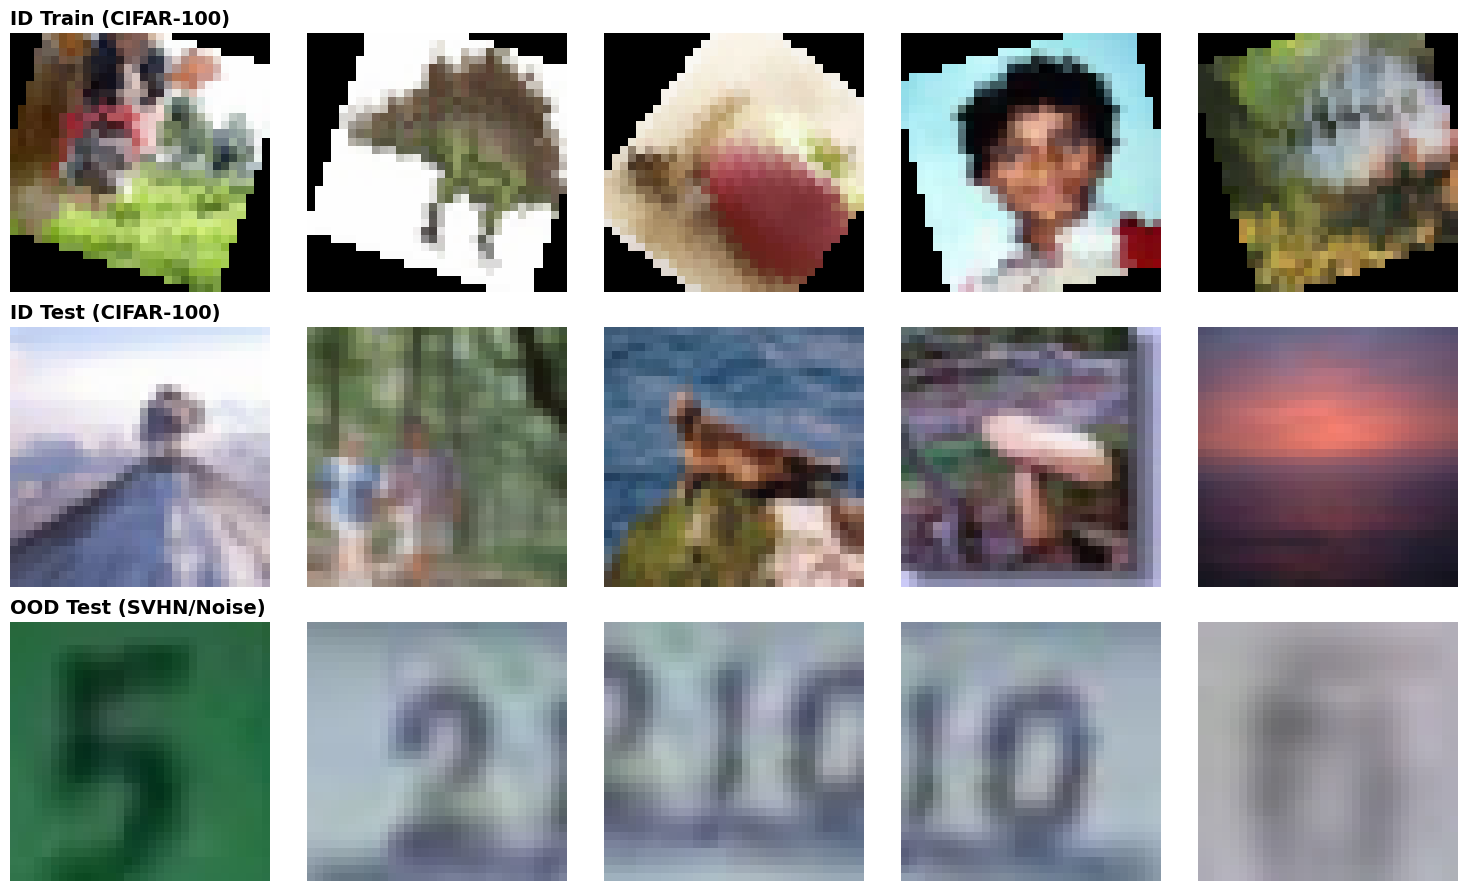

In [3]:
def show_loader_images(loaders_dict, n=5):
    """
    Visualizes a grid of sample images from multiple DataLoaders.
    
    This function is primarily used to qualitatively inspect In-Distribution (ID) 
    and Out-of-Distribution (OOD) data, ensuring that preprocessing and 
    normalization are correctly applied across different sources.

    Args:
        loaders_dict (dict): Dictionary mapping dataset names to their respective DataLoaders.
        n (int): Number of images to display per loader (columns in the grid).
    """
    
    fig, axes = plt.subplots(len(loaders_dict), n, figsize=(15, 9))
    
    mean = np.array([0.5071, 0.4867, 0.4408])
    std = np.array([0.2675, 0.2565, 0.2761])

    for row, (name, loader) in enumerate(loaders_dict.items()):
        inputs, _ = next(iter(loader))
        
        for col in range(n):
            img = inputs[col].numpy().transpose((1, 2, 0)) # C, H, W -> H, W, C
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            ax = axes[row, col]
            ax.imshow(img)
            ax.axis('off')
            if col == 0:
                ax.set_title(name, loc='left', fontweight='bold', fontsize=14)

    plt.tight_layout()
    plt.show()

loaders_to_show = {
    "ID Train (CIFAR-100)": train_loader,
    "ID Test (CIFAR-100)": test_loader,
    "OOD Test (SVHN/Noise)": ood_loader
}

show_loader_images(loaders_to_show)

In [4]:
pca = PCA(n_components=num_principal_comp)
pca.fit(id_train_features.numpy())

u = torch.from_numpy(pca.mean_).float()
w = torch.from_numpy(pca.components_).float()

weight_fc = model.base_model.fc.weight.detach().cpu()
bias_fc = model.base_model.fc.bias.detach().cpu()


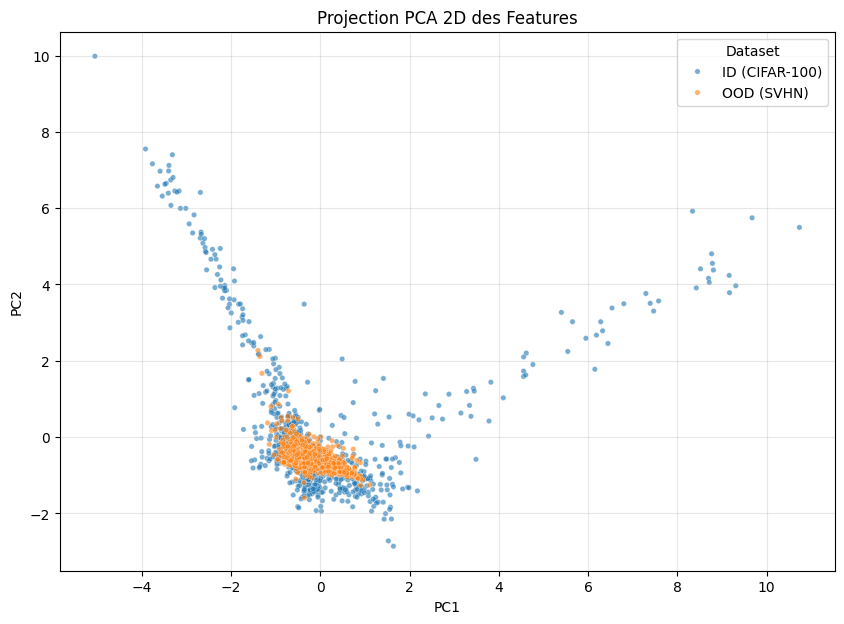

In [5]:
def plot_pca_2d(id_feats, ood_feats, n_samples=1000):
    pca_2d = PCA(n_components=2)
    pca_2d.fit(id_feats.numpy())
    
    id_projected = pca_2d.transform(id_feats.numpy()[:n_samples])
    ood_projected = pca_2d.transform(ood_feats.numpy()[:n_samples])
    
    df_id = pd.DataFrame(id_projected, columns=['PC1', 'PC2'])
    df_id['Dataset'] = 'ID (CIFAR-100)'
    
    df_ood = pd.DataFrame(ood_projected, columns=['PC1', 'PC2'])
    df_ood['Dataset'] = 'OOD (SVHN)'
    
    df_plot = pd.concat([df_id, df_ood])
    
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Dataset', alpha=0.6, s=15)
    plt.title('Projection PCA 2D des Features')
    plt.grid(True, alpha=0.3)
    plt.show()

plot_pca_2d(id_features, ood_features)

MSP	La confiance après Softmax.	Le modèle est souvent "overconfident" même sur du n'importe quoi.
Energy	La "physique" des logits (énergie libre).	Meilleur que MSP, mais ne regarde pas les caractéristiques internes.
Mahalanobis	Si le vecteur de l'image est "proche" du centre des classes connues.	Sensible à la qualité des features extraites.
ViM	La partie de l'image qui ne "rentre pas" dans les dimensions principales de la PCA.	C'est le plus robuste pour détecter des images avec des textures/formes inconnues.

In [6]:
def evaluate_ood_performance(id_scores, ood_scores):
    """Calculates AUROC for a given set of scores."""
    id_s = id_scores.cpu().numpy() if torch.is_tensor(id_scores) else id_scores
    ood_s = ood_scores.cpu().numpy() if torch.is_tensor(ood_scores) else ood_scores
    
    # Label 1 for In-Distribution, 0 for Out-of-Distribution
    labels = np.concatenate([np.ones(len(id_s)), np.zeros(len(ood_s))])
    total_scores = np.concatenate([id_s, ood_s])
    
    return roc_auc_score(labels, total_scores)

results = {
    "MSP": {
        "scores": (score_msp(id_logits), score_msp(ood_logits)),
        "desc": "Confidence (0 to 1)",
        "logic": "Higher = More likely ID"
    },
    "Energy": {
        "scores": (score_energy(id_logits), score_energy(ood_logits)),
        "desc": "Free Energy logsumexp",
        "logic": "Higher = Lower Energy (ID)"
    },
    "Mahalanobis": {
        "scores": (score_mahalanobis(id_features, id_mean, id_precision), 
                   score_mahalanobis(ood_features, id_mean, id_precision)),
        "desc": "Negative Dist. to Clusters",
        "logic": "Higher = Closer to ID means"
    },
    "ViM": {
        "scores": (score_vim(id_features, id_logits, w, bias_fc, u, None),
                   score_vim(ood_features, ood_logits, w, bias_fc, u, None)),
        "desc": "Logit - PCA Residual",
        "logic": "Higher = Typical ID structure"
    }
}


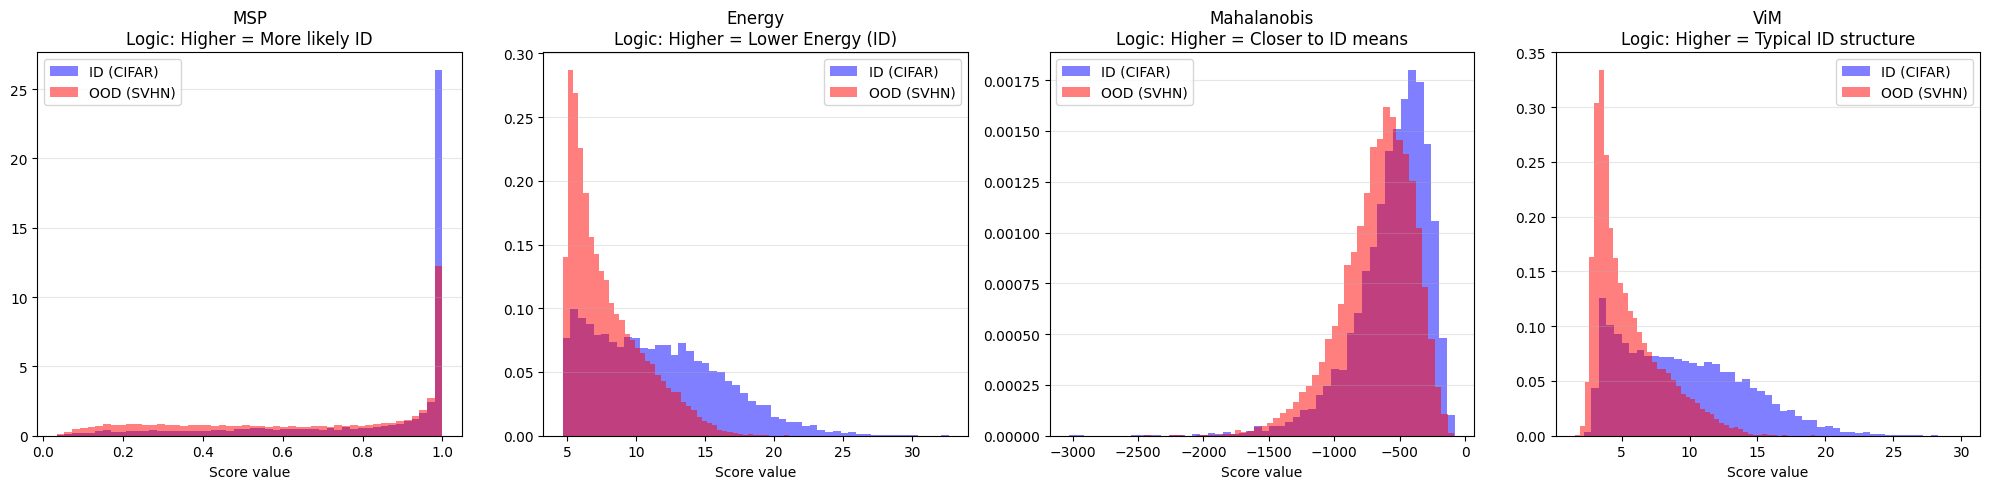

In [7]:
def plot_all_ood_distributions(results_dict):
    """
    Plots the probability density distributions of OOD scores for all metrics.
    
    This visualization compares In-Distribution (ID) vs. Out-of-Distribution (OOD) 
    score overlap. A clear separation between distributions indicates a 
    high-performing metric.

    Formula (Density):
        f(x) = P(X = x), normalized such that area under curve = 1.
    """
    
    n_methods = len(results_dict)
    fig, axes = plt.subplots(1, n_methods, figsize=(5 * n_methods, 5))
    
    for i, (name, info) in enumerate(results_dict.items()):
        id_s, ood_s = info["scores"]
        
        id_s = id_s.cpu().numpy() if hasattr(id_s, 'cpu') else id_s
        ood_s = ood_s.cpu().numpy() if hasattr(ood_s, 'cpu') else ood_s
        
        ax = axes[i]
        ax.hist(id_s, bins=50, alpha=0.5, label='ID (CIFAR)', color='blue', density=True)
        ax.hist(ood_s, bins=50, alpha=0.5, label='OOD (SVHN)', color='red', density=True)
        
        ax.set_title(f"{name}\nLogic: {info['logic']}")
        ax.set_xlabel("Score value")
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_all_ood_distributions(results)

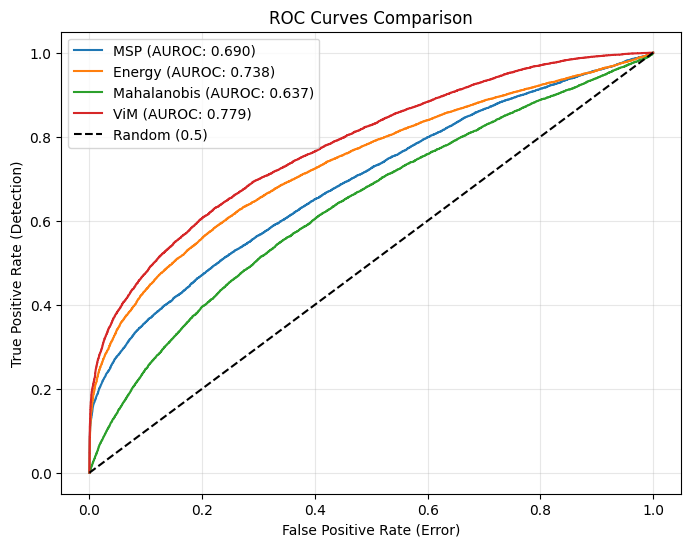

In [8]:
def plot_roc_curves(results_dict):
    """
    Plots Receiver Operating Characteristic (ROC) curves for all OOD metrics.
    
    The ROC curve illustrates the diagnostic ability of each metric by varying 
    the binary threshold. A metric with an area under the curve (AUROC) near 1.0 
    indicates near-perfect separation between ID and OOD.

    Formula (ROC):
        Y-axis: True Positive Rate (TPR) = TP / (TP + FN)
        X-axis: False Positive Rate (FPR) = FP / (FP + TN)
    """
    
    plt.figure(figsize=(8, 6))
    
    for name, info in results_dict.items():
        id_s, ood_s = info["scores"]
        id_s = id_s.cpu().numpy() if hasattr(id_s, 'cpu') else id_s
        ood_s = ood_s.cpu().numpy() if hasattr(ood_s, 'cpu') else ood_s
        
        labels = np.concatenate([np.ones(len(id_s)), np.zeros(len(ood_s))])
        scores = np.concatenate([id_s, ood_s])
        
        fpr, tpr, _ = roc_curve(labels, scores)
        plt.plot(fpr, tpr, label=f"{name} (AUROC: {evaluate_ood_performance(id_s, ood_s):.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label="Random (0.5)")
    plt.xlabel('False Positive Rate (Error)')
    plt.ylabel('True Positive Rate (Detection)')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

plot_roc_curves(results)

In [ ]:
import torch

def score_neco(features, means, num_principal_components=None):
    """
    Computes the Neural Collapse Inspired OOD (NECO) score.
    
    This metric isolates the Neural Collapse subspace (spanned by the Simplex ETF)
    and evaluates the trade-off between the feature's norm in the valid 
    semantic subspace and its orthogonal residual component.
    
    Formula:
        f_centered = f - mu_G
        f_proj = V_{1:K-1} * V_{1:K-1}^T * f_centered
        f_res = f_centered - f_proj
        S(x) = ||f_proj||_2 - ||f_res||_2
    """
    if num_principal_components is None:
        num_principal_components = means.shape[0] - 1
        
    mu_g = means.mean(dim=0)
    features_centered = features - mu_g
    means_centered = means - mu_g
    
    _, _, vh = torch.linalg.svd(means_centered, full_matrices=False)
    
    # Subspace spanned by class means (Simplex ETF)
    id_basis = vh[:num_principal_components].T 
    
    projected = features_centered @ id_basis @ id_basis.T
    residual = features_centered - projected
    
    energy_id = torch.norm(projected, dim=1)
    energy_ood = torch.norm(residual, dim=1)
    
    return energy_id - energy_ood

def get_class_means(features, labels, num_classes=100):
    """
    Computes the empirical centroid for each class in the latent space.
    
    Formula:
        mu_c = (1 / N_c) * sum_{i : y_i = c} f_i
    """
    means = []
    for i in range(num_classes):
        mask = (labels == i)
        if mask.sum() > 0:
            means.append(features[mask].mean(dim=0))
        else:
            means.append(torch.zeros(features.size(1), device=features.device))
    return torch.stack(means)

train_labels = torch.cat([labels for _, labels in train_loader])

class_means_matrix = get_class_means(id_train_features, train_labels)

neco_id = score_neco(id_features, class_means_matrix)
neco_ood = score_neco(ood_features, class_means_matrix)


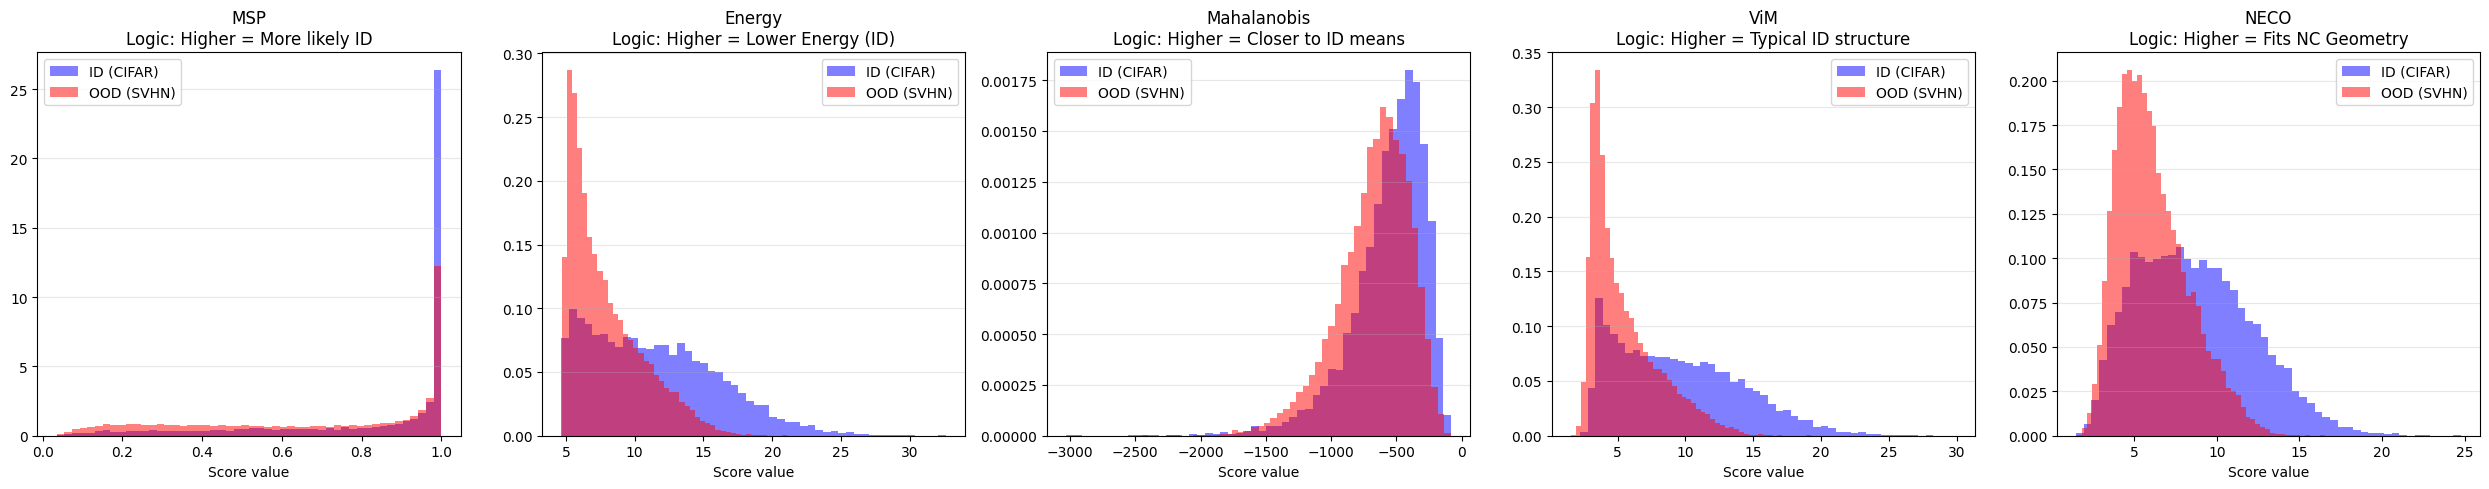

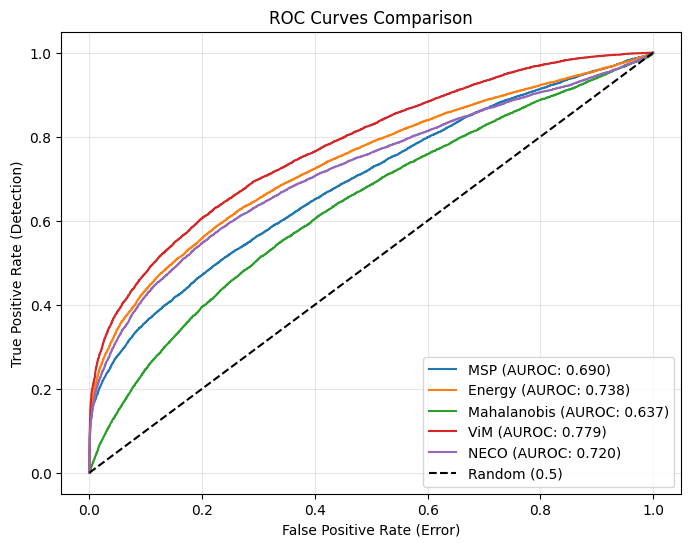

In [14]:
results["NECO"] = {
    "scores": (neco_id, neco_ood),
    "desc": "NC Projection / Residual",
    "logic": "Higher = Fits NC Geometry"
}

plot_all_ood_distributions(results)
plot_roc_curves(results)